### <p style="text-align: right;"> &#9989; Yaqi</p>

#### <p style="text-align: right;"> &#9989; Eren, Mingda, Yun</p>

# Day 13 In-class Assignment: Exploring social dynamics with agent-based models

In this in-class assignment we'll continue to explore the one-dimensional Schelling model and we'll try to understand how changing some of the parameters of the model changes the outcomes.

<img src="http://www.radicalcartography.net/chicagodots_race_big.jpg" width=400px>

## Learning Goals

We want you to:

- Think about modeling Thomas Schelling's 1974 research: a complex system where a slight bias in individual preference leads to a large-scale effect
- Try turning Schelling's rules for movement into code
- Run a Schelling simulation until it terminates
- Explore how changes in the simulation parameters change the outcomes

---
# Contexting our model

Segregation by race, social class and other factors is a long-standing and pernicious problem in the United States.  Segregation is a complicated problem, whose causes have been historically driven by racial animosity.  Racial segregation has a long and dark history, and was once pervasively enforced by the government.  Although much effort has been extended to desegregate schools, churches and neighborhoods, segregation along racial and economic lines continues to persist in the United States.

Although incomplete, simple models can be used to help understand this phenomenon and how it can be reversed. As you saw in the pre-class assignment, **Nicky Case** developed a game-based model that explores simple rules in a 2D world to see how small-scale individual preferences can have larger effects on society called the "[Parable of the Polygons](http://ncase.me/polygons/)".

Earlier, an economist [Thomas Schelling](https://en.wikipedia.org/wiki/Thomas_Schelling) published a simpler, 1D model in what would become a landmark paper called "[Dynamic Models of Segregation](https://www.stat.berkeley.edu/~aldous/157/Papers/Schelling_Seg_Models.pdf)." In it, Schelling tried to explore how, in a simple toy system, individuals segregate themselves even if they have an expressed preference for having neighbors different from themselves. In other words: Schelling explored how small individual preferences can lead to larger-scale social segregation, where 'like' people clump together.

---

# Reminder, the rules of the Schelling model

Here's how Schelling sets up the rules for a 1-dimensional simulation:

## Whether a resident wants to move

- Everybody wants at least half their neighbors to be like themselves 
- Everyone defines 'their neighborhood' to include the four nearest neighbors on either side of them
- A star wants at least four of their eight nearest neighbors to also be stars
- A zero wants at least four of their eight nearest neighbors to also be zeros
- For those near the end of the line the rule is that, of the four neighbors on the side toward the center plus the one, two or three outboard neighbors, half must be like oneself (Hint: this rule gets at the idea of who the neighbors are for people near the end of the line, e.g. if you're 3 people from the end, you only have 2 neighbors on the outside of where you're at.)

## How a resident moves

- A dissatisfied resident moves to the nearest point that meets their minimum demand---the nearest point at which half of their neighbors will be like themselves when they arrive there
- 'Nearest' means the point reached by passing the smallest number of neighbors on the way
- A resident moves by shoving themselves between any two other residents. (It's a bit like cutting in a line/queue: if you want to cut in, you just kind of insert yourself between two people already in line and the rest of the line adjusts around you)

## The order of moves

- Arbitrarily let the discontented members (those who have fewer than four neighbors like themselves) move in turn, counting from left to right.

## Who gets to move, and when

- Only discontented members are eligible to move
- When people become happy, they don't want to move anymore. If an originally discontented member (when the game started) ends up content when their turn comes up, they stay put. (e.g. They used to be unhappy, someone moved, and now they're content.)
- Anyone who *becomes* discontent gets a turn *after* the originally unhappy people get to move. (This rule is a little tricky, so make sure you feel like you comfortably understand it.)
- The definition of a neighborhood is the four nearest neighbors on either side **at the moment one decides to move or stay**; if someone moves in between a resident and their next-door neighbor, they push the fourth neighbor out of the neighborhood. (If a line is 100 people long, the theater only fits 100 people, and you cut somewhere in line, then whoever was last in line isn't getting into the theater. Womp womp. Note that doesn't mean that the overall population changes, but a individual's neighborhood could change as other individuals move.)

## What residents know about other residents

- The residents don't think ahead; if it's their turn to move, they base their decision only on the state of their neighborhood as they see it, on that turn. They don't plan ahead, and they don't try to figure out what the other neighbors *might* do. 


---
# Coding up the Schelling model

In your pre-class assignment you started turning the Schelling model into code and tested out a function to determine in a given person was happy in their location. Now we're going to figure out how to move people within our population based on whether or not they are happy or unhappy.

### Critical Function 1: Creating a game board

This function might look similar to the version you created in your pre-class assignment. If you like the one you wrote in your pre-class assignment better, feel free to use that one. The function defines people are being 0's or 1's. At each initial location, there is 50% probability that a person is either a 0 or 1. The default size of the population is 32, but you can make it as big or as small as you want. Since we're using a random number generator, we also input a random seed we want to use so that we can get reproducible results (there is a default for this as well). The function returns the NumPy array that it creates.

In [1]:
import numpy as np

def initialize_board(n_people=32, seed=1234):
    # Set the seed for the random number generator
    np.random.seed(seed)
    
    # Generate an array using a random number generator
    # such that ever spot is defined to be zero or one
    # where there is an equal chance that a spot is
    # either a zero or a one.
    world = np.random.choice([0,1],n_people)
    
    # return the newly created population
    return world

# Test it out:
people = initialize_board(20)
print(people)

[1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0]


### Critical Function 2: Deciding if an agent is happy

This function takes a game board generated by the first function and determines whether an agent at position *i* in the game board is happy for a game board of any size and a neighborhood of size N (i.e., from position i-N to i+N) for a given tolerance (the default is 50%), and returns that information.

The code has to make sure to check that position *i* is actually inside the game board (i.e., make sure the request makes sense), and ensure that it behaves correctly for agents near the edges of the game board.

**Make sure you read through the code and understand what it does!**

In [2]:
def is_happy(my_list, my_index, tol_prob=0.5, neighbor_N=4):
    '''
    This function take a game board (my_list) and checks to see if the agent
    at the given index (my_index) is "happy" or "unhappy" based on a provided
    tolerance (tol_prob) and a given neighborhood size (neighbor_N).
    It returns 'True' if happy and 'False' if unhappy under those circumstances.
    '''
    # do some error-checking (is the index within the allowed range?)
    if my_index < 0 or my_index > len(my_list)-1:
        print("you've made an indexing error!", my_index)
        return
       
    # Grab my value so that I can compare to my neighbors
    my_value = my_list[my_index]
    
    # Based on the size of my neighborhood, figure out my search range
    start = max(my_index - neighbor_N, 0) # start 4 to the left
    end = min(my_index + neighbor_N, len(my_list)-1) # end 4 to the right
    
    # counter for keeping track of the neighbors that are like me
    neighbors_like_me = 0
    
    # counter for keeping track of total neighbors
    total_neighbors = 0
    
    # loop over the specified range
    for i in range(start,end+1):
        if i == my_index:
            continue # don't count myself
        if my_list[i] == my_value:  # if this neighbor is like me, keep track of that
            neighbors_like_me += 1
        total_neighbors+=1  # also keep track of total neighbors
    
    # happy if at least half are like me, unhappy otherwise
    # note: it's at least half because we're not double-counting our
    # own value
    if neighbors_like_me/total_neighbors >= tol_prob:
        return True
    else:
        return False
    
# Test it out:
print(is_happy(people,2))

True


### Critical Function 3:  Deciding where to move when an agent is unhappy

Now that we have a way of determine if a particular person is happy or not, we need to figure out where unhappy people should move in order to become happy. Keep in mind that the rules say that we want to move the least possible distance to become happy.

**Write a function that takes as inputs the current board and the location of an unhappy agent and returns the index of where it should move to**. There is a skeleton function provided below with some comments that provides sections for how you might go about this. Of course, if these comments don't make sense to you or aren't how you would go about it, feel free to try your own approach. There is rarely one "right" way to write code!

**Important Note**: When working with NumPy arrays, if I want to move a value from its current position to a new position, one good way to do this is to "delete" that value from the array and the "insert" that value into a new location. The NumPy functions that do this are `np.delete()` and `np.insert()`. You'll want to look into how those functions work.

In [60]:
# Finish the function below for deciding where to move agents
def where_to_move(my_list, my_index, tol_prob=0.5, neighbor_N=4, print_output=False):
    '''
    Given a population (my_list), and the index of an unhappy person (my_index),
    this function figures out where to move my_value so that it's happy.
    This assumes that my_value is unhappy where it is, by the way!
    This function then returns the index where my_value
    should move to in order to be happy.
    
    Note that the function has to take in the same tolerance probability
    and neighborhood size as the "is_happy" function to make sure it correctly moves people.
    '''
    # Figure out what my current value is so that I can correctly move
    # myself to check for possible happiness
    my_value = my_list[my_index]
    
    # Create a value for tracking whether or not I'm happy
    happy = False
    
    # Create a variable to store where I should be move to
    # We set it to -1 so that we know if we failed to find
    # a happy place when we do our seearch
    new_index = -1
    
    # Remove myself from the array so that I can insert myself
    # in a new location, store that new location in a temporary array
    # (the np.delete function might be new to you,
    #  so make sure you understand what it does)
    temp_list = np.delete(my_list, my_index)
    
    # Create a loop that will try new positions until it finds one I'm happy in.
    # Initially we'll only look to move one spot in either direction.
    # We include a check to check for happiness and a check to make sure we aren't
    # searching too far.
    i = 1

    while (happy == False) and (my_index - i >= 0 or my_index + i <= (len(my_list)-1)):
        # Try moving to the left (make sure we don't step out of the bounds of the array)
        # I can do this by "inserting" myself into the array I removed myself from
        #  "np.insert()" is the function we want for this!
        
        # Check if this new location makes me happy. Remember, we have a function for this!
        happy_r = False
        happy_l = False
        if my_index-i >= 0:
            insert_list = np.insert(temp_list,my_index-i,my_value)
            happy_l = is_happy(insert_list,my_index-i)
        
        # Try moving to the right (make sure we don't step out of the bounds of the array)
        # Use the same method as moving to the left
        
    
        # Check if this new location makes me happy. Remember, we have a function for this!
        if my_index+i < len(my_list):
            insert_list = np.insert(temp_list,my_index+i,my_value)
            happy_r = is_happy(insert_list,my_index+i)
        # Check to see if moving to the left made me happy,
        # If so, define the new index that I need to move to.
        # If not, check if the move to the right made me happy
        # and update the index if it did.
        # You could also considering include a print statement
        # that says where you should move to be happy.
        # Make sure that if I found a location that made me happy
        # that I update the value of my "happy" variable so that the loop exits!
        if happy_l == True:
            new_index = my_index-i
            happy = True
           # print('move to',new_index,'make me happy!')
        if happy_r == True:
            new_index = my_index+i
            happy = True
           # print('move to',new_index,'make me happy!')
        
        # If neither option is a happy move expand our search by one
        # before returning to the top of the loop
        i += 1
    
    # Finally, check to see if we succeeded in finding a place to move to.
    if new_index == -1:
        print ("something has gone wrong with where_to_move! probably couldn't find a happy place.")
    
    return new_index  

**Note**: As you build your function, write some code down here to test it out. Try creating a sufficiently small world so that you can check by hand to see whether or not the code is identifying the right location to move people to.

In [28]:
# Put test code here
b = initialize_board(10,2)
print(b)
for i in range(len(b)):
    print(is_happy(b,i))

[0 1 1 0 0 1 0 1 0 1]
True
False
False
False
True
True
False
False
False
True


In [29]:
where_to_move(b,2)

move to 5 make me happy!


5

In [30]:
help(np.insert)

Help on function insert in module numpy:

insert(arr, obj, values, axis=None)
    Insert values along the given axis before the given indices.
    
    Parameters
    ----------
    arr : array_like
        Input array.
    obj : int, slice or sequence of ints
        Object that defines the index or indices before which `values` is
        inserted.
    
        .. versionadded:: 1.8.0
    
        Support for multiple insertions when `obj` is a single scalar or a
        sequence with one element (similar to calling insert multiple
        times).
    values : array_like
        Values to insert into `arr`. If the type of `values` is different
        from that of `arr`, `values` is converted to the type of `arr`.
        `values` should be shaped so that ``arr[...,obj,...] = values``
        is legal.
    axis : int, optional
        Axis along which to insert `values`.  If `axis` is None then `arr`
        is flattened first.
    
    Returns
    -------
    out : ndarray
        A

---
## Extra useful functions.

The following two functions do the following:

1. `find_all_unhappy` locates all of the unhappy people in a given board
2. `make_moves` uses the list of unhappy people and the `where_to_move` function that you wrote to move people in order to maximize the overal perceived happiness.

In [40]:
def find_all_unhappy(my_list):
    '''
    This function takes the board and identifies
    all the locations that are currently unhappy and returns
    as list of the indices. We can use this list to move
    people.
    '''
    unhappy_people = []
    for i,person in enumerate(my_list):
        happy = is_happy(my_list, i)
        if happy == False:
            unhappy_people.append(i)
    return unhappy_people

In [61]:
def make_moves(my_list, unhappy, tol_prob=0.5, neighbor_N=4, print_output=False):
    '''
    This function takes a board and a list of unhappy
    people. It steps through the list of unhappy people
    and moves them to the location where they will be happy.
    It also need to make sure that when one person moves that
    the positions of the other unhappy people are shuffle accordingly.
    Before those people are moved, we need to check if they
    ended up happy by accident when the other people moved.
    If so, we can leave them alone.
    
    This function returns all of the intermediate states
    of the board as well as the final state.
    '''
    intermediate = np.array([])
    unhappy = np.array(unhappy)
    for i in range(len(unhappy)):
        # Check to see if the unhappy person became happy.
        # If so, move on without moving anyone
        if is_happy(my_list,unhappy[i]):
            if print_output:
                print("I'm not unhappy anymore")
            continue
            
        # Grab my value so that I can move it later
        my_value = my_list[unhappy[i]]
        
        # Figure out where I need to move to
        new_index = where_to_move(my_list, unhappy[i], tol_prob=tol_prob,
                                  neighbor_N=neighbor_N, print_output=print_output)
        if new_index == -1:
            #Move on to the next unhappy person,
            # perhaps there wasn't a place to move this one
            continue
        
        # Move me
        new_list = np.delete(my_list, unhappy[i])
        new_list = np.insert(new_list, new_index, my_value)
        
        # Update the indexes of the unhappy people
        # that may have shifted when the other unhappy person moved
        if new_index < unhappy[i]:
            unhappy[i+1:][unhappy[i+1:] == new_index] += 1
        if new_index > unhappy[i]:
            unhappy[i+1:][unhappy[i+1:] <= new_index] -= 1
        unhappy[i] = new_index
        
        my_list = new_list.copy()
        if print_output:
            print(my_list)
        intermediate = np.append(intermediate,my_list)
        
    return my_list, intermediate

---
## Putting it all together

The following code puts all of the above pieces together to run a simulation and plot the result as the simulation evolves. Try changing the initial size of the board, the size of the neighborhood that people care about, and the tolerance for living next to different versus the same people. Watch out for runaway simulation. **For some parts of parameter space the model either takes a long time to converge to a steady state solution, or may never converge. The code makes sure to stop the code eventually, even if there are still too many "unhappy" peoiple.** In particular, if you try making the neighborhood too small, you tend to run into simulations that never converage because people keep trying to move around. You may also run into issues for values of "tolerance" that are greater than 0.8.

Note that this code uses `imshow()` in a way that is different than you might be used to. Each vertical line of the image is actually one state of the board. As you move to the right in the image, you move forward in time. This is a useful way to visualize the behavior of a 1D world!

In this model, you should see that people of the same type end up clustering together over time.

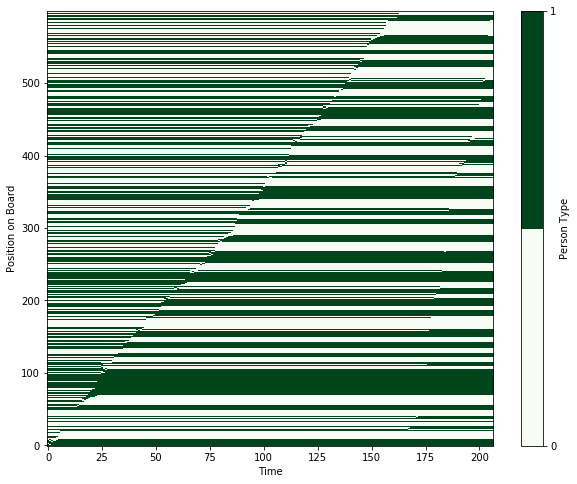

In [63]:
# Put it all together

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,8))

# Create an array for storing all states of the board
all_snapshots = np.array([])

# Create the initial board
people = initialize_board(600, seed=7)

# Append this board to the array of all states
all_snapshots = np.append(all_snapshots,people)

# Find the unhappy people
unhappy = find_all_unhappy(people)

# Run the loop until less than 5% of the population is unhappy
# or until 300 iterations have occurred (to avoid an infinite loop)
iter_count = 0
while (len(unhappy) > (0.05 * len(people))) and (iter_count < 300):
    new_people,intermediate = make_moves(people, unhappy, tol_prob=0.5, neighbor_N=4)
    all_snapshots = np.append(all_snapshots,intermediate)
    all_snapshots = np.append(all_snapshots,new_people)
    
    unhappy = find_all_unhappy(new_people)
    people = new_people.copy()
    iter_count += 1

# Check to see if the solution may not have reached convergend
if iter_count >= 300:
    print("WARNING: This solution may not be converged!")
    
# Make a plot of our evolving world
cmap = plt.cm.get_cmap('Greens', 2)
plt.imshow(np.reshape(all_snapshots, (int(len(all_snapshots)/len(people)),len(people))).T,
           cmap=cmap, origin="lower", aspect='auto')
plt.ylabel("Position on Board")
plt.xlabel("Time")
cb = plt.colorbar()
cb.set_ticks([0,1])
cb.set_label("Person Type")

**Question** What behavior do you see emerge as you vary different parameters? Do the results behave as you would expect?

If the number of residents is very small, each racial tends to live together and cause a situation like all 1s live in the left side and all 0s live in the other side. As the number grows, it tends to be a little bit more dispersive.

It behaves as I expect.

---
## Thinking about a 2D Schelling-type model

In your pre-class assignment, you explored a 2D version of the Schelling model created by **Nicky Case**, the "[Parable of the Polygons](http://ncase.me/polygons/)".

Revisit this model and think about how you would write the code for this 2D model. How does it compare to the code that you wrote for the forest fire model? How is it different? **Write your answers below.**

*Answer goes here!*

If time allows, work with your group to write out some pseudo-code or diagrams on the whiteboards for how you would code up this game. Think about:

1. What are the individual pieces of this model?  (In other words, if you had to break the model down into individual functions, what would they be?)
2. If you had to create a flowchart to describe this model, what would it look like?  (Using the functions you brainstormed in the previous point.)
3. How do you think that the function that decides whether a shape is happy, unhappy, or meh works?
4. How do you think that the segregation metric is calculated?

You need to consider how to set up the 2D world and how you would determine whether or not and person needs to move. You'd also have to plan out how you would go about identifying an empty space to move them to automatically. Think about how you would handle the case where a person wants to move if their neighborhood is not diverse enough, in contrast to being too diverse. How would you handle the case the in between case where a person wants to be both by people like them, but not too many people like them? How would you track their state of being as unhappy, happy, or meh? **Record some of your thoughts below**

*Record your thoughts here!*

---


## Congratulations, you're done!

Submit this assignment by uploading your notebook to the course Desire2Learn web page.  Go to the "In-Class Assignments" folder, find the submission link for Day 13, and upload everything there. Make sure your name is on it!

&#169; Copyright 2018,  Michigan State University Board of Trustees